In [148]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
%matplotlib inline

from myUtils import *
from plottingUtils import *

In [149]:
#hyperparameters

data_dir = "./datasets/PJM_power/"
fname = "DAYTON_hourly.csv"

sample_len = 240
step = 1
target_len = 48
batch_size = 64
steps_in_day = 24

HID_DIM = 64
N_LAYERS = 4
DROPOUT = 0.5

desired_features = None

In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [151]:
class Encoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

    def forward(self, src):
        # src = [batch size, src len, n]
        outputs, hidden = self.rnn(src)

        # outputs = [batch size, src len, hid dim]
        # hidden = [batch size, n layers, hid dim]

        return hidden

In [152]:
class Decoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_features = n_features
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc_out = nn.Linear(hid_dim, n_features)

    def forward(self, input, hidden):
        # input = [batch size, n features]
        # hidden = [batch size, n layers, hid dim]
    
        input = input.unsqueeze(1)
        # input = [batch size, 1, n features]

        output, hidden = self.rnn(input, hidden)
        # output = [batch size, 1, hid dim]
        # hidden = [batch size, n layers, hid dim]
        
        prediction = self.fc_out(output.squeeze(1))

        # prediction = [batch size, n features]

        return prediction, hidden

In [153]:
class Seq2Seq(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout, device):
        super().__init__()

        self.encoder = Encoder(n_features, hid_dim, n_layers, dropout).to(device)
        self.decoder = Decoder(n_features, hid_dim, n_layers, dropout).to(device)
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch size, src len, n features]
        # trg = [batch size, trg len, n features]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        # tensor to store decoder outputs
        outputs = torch.zeros_like(trg)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src)
        # first input to the decoder is the last sample
        input = src[:, -1]
        trg_len = trg.shape[1]

        for t in range(trg_len):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden = self.decoder(input, hidden)
            # place predictions in a tensor holding predictions for each token
            outputs[:, t] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[:, t] if teacher_force else output

        return outputs

In [154]:
# model fitting



def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    desired_features=None,
    teacher_forcing_ratio=0.5,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation, if None then all features
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)

    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # y = y.unsqueeze(1).to(torch.float)
        # Compute prediction error

        pred = model(x, y, teacher_forcing_ratio=teacher_forcing_ratio)

        if desired_features is not None:
            # calculate loss using only desired features
            pred = pred[:, :, desired_features]
            y = y[:, :, desired_features]
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


def eval(
    dataloader, 
    model, 
    loss_fn, 
    iter_count=None, 
    desired_features=None, 
    visibility=True
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)
            # y = y.unsqueeze(1).to(torch.float)
            pred = model(x, y, teacher_forcing_ratio=0)
            if desired_features is not None:
                pred = pred[:, :, desired_features]
                y = y[:, :, desired_features]

            test_loss += loss_fn(pred, y).item()

    test_loss /= iter_count

    return test_loss


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    desired_features=None,
    teacher_forcing_ratio=0.5,
    visibility = 0,
    save_model = False
):
    '''
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    desired_features: list of features to be used in loss calculation
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    '''
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            desired_features=desired_features,
            teacher_forcing_ratio=teacher_forcing_ratio,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        test_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            desired_features=desired_features,
            visibility=(visibility == 2),
        )

        if min_val_loss > test_loss and save_model:
            min_val_loss = test_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:>8f} ")
            print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(test_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    
    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")

    
    return history

In [155]:
# preprocessing


df = extract_dataframe(data_dir, fname)
df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
normalized_data, mean, std = normalize_data(float_data)

In [156]:
timesteps = len(float_data)
print(f'{timesteps} timesteps')

121275 timesteps


In [157]:

train_max_index = int(timesteps * 0.7)

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=train_max_index,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=train_max_index+1,
    max_index=timesteps,
    shuffle=True,
    step=step,
    batch_size=batch_size
)



DAYTON_MW


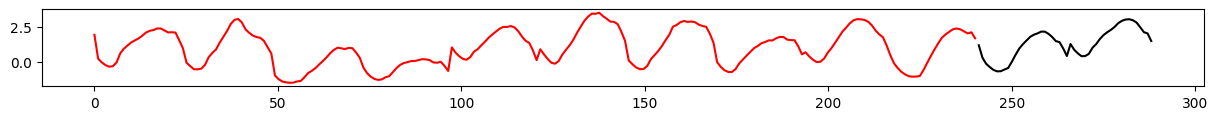

DAYTON_MW_Diff


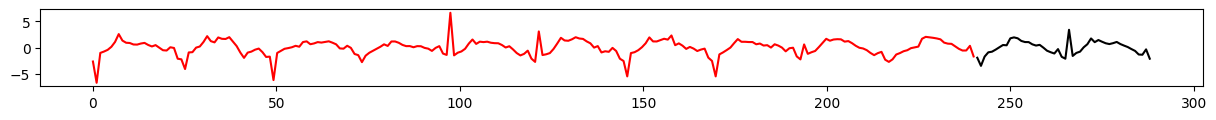

DAYTON_MW_DailyAvg


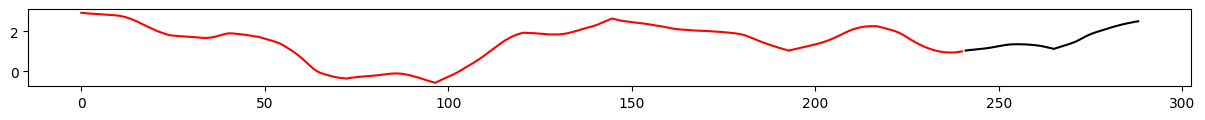

DAYTON_MW_DailyDiff


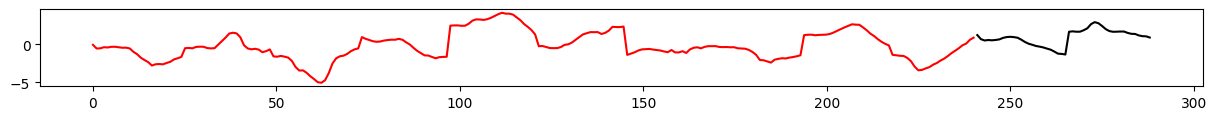

In [158]:
samples, targets = next(train_generator)
for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

In [159]:

N_SAMPLES = float_data.shape[1]

model = Seq2Seq(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT, device).to(device)
#model = Iterative(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT).to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(4, 64, num_layers=4, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (rnn): GRU(4, 64, num_layers=4, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [160]:


summary(model,input_size=[(10, sample_len, N_SAMPLES), (10, target_len, N_SAMPLES)],col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"], col_width=15,)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Seq2Seq                                  [10, 240, 4]    [10, 48, 4]     --              True            --
├─Encoder: 1-1                           [10, 240, 4]    [4, 10, 64]     --              True            --
│    └─GRU: 2-1                          [10, 240, 4]    [10, 240, 64]   88,320          True            --
├─Decoder: 1-2                           [10, 4]         [10, 4]         --              True            --
│    └─GRU: 2-2                          [10, 1, 4]      [10, 1, 64]     88,320          True            --
│    └─Linear: 2-3                       [10, 64]        [10, 4]         260             True            --
├─Decoder: 1-3                           [10, 4]         [10, 4]         (recursive)     True            --
│    └─GRU: 2-4                          [10, 1, 4]      [10, 1, 64]     (recursive)     True            --
│    └─Linear: 2-5

In [161]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 176,900 trainable parameters


In [162]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_iter_count=100,
    val_dataloader=val_generator,
    val_iter_count=50,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=50,
    desired_features=desired_features,
    save_model=True,
    visibility=1
)

100%|██████████| 50/50 [05:47<00:00,  6.95s/it]

Total Duration: 0:5:47.466
Average Duration: 0:0:6.949


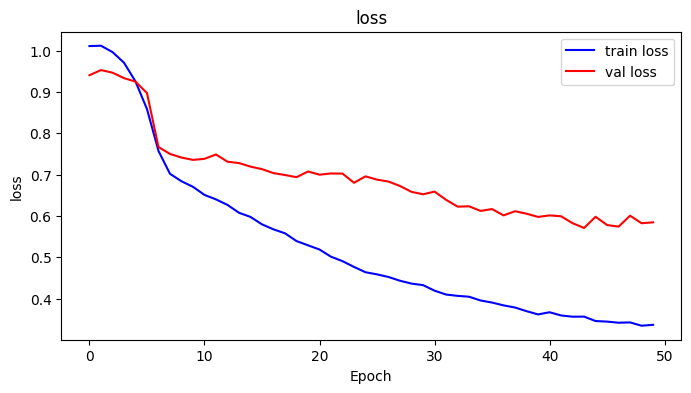

In [163]:
plot_history(history)

In [164]:


def make_predictions(model, samples, targets):
    with torch.no_grad():
        output = model(samples.to(device), targets.to(device), teacher_forcing_ratio=0)
    return output





torch.Size([64, 48, 4])
DAYTON_MW


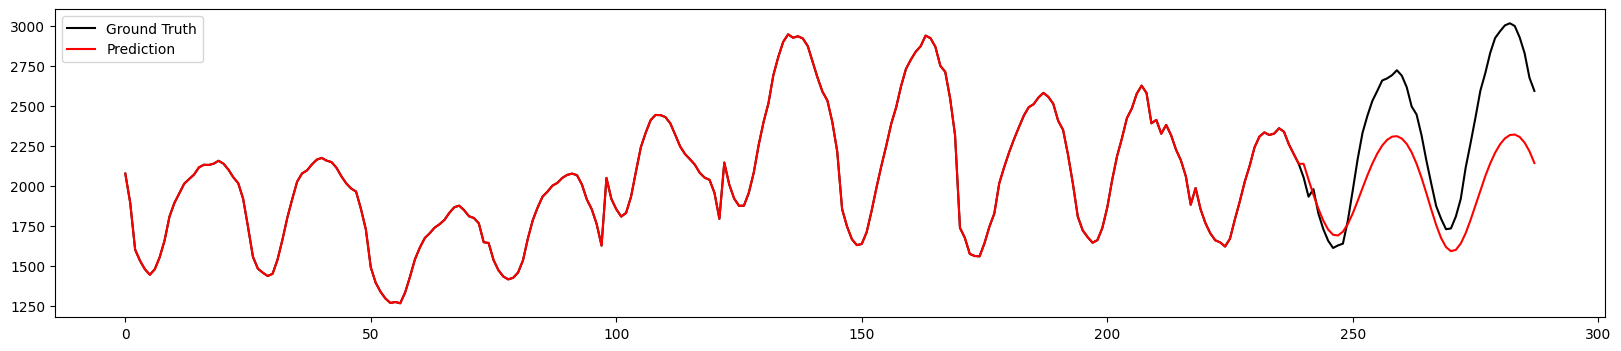

DAYTON_MW_Diff


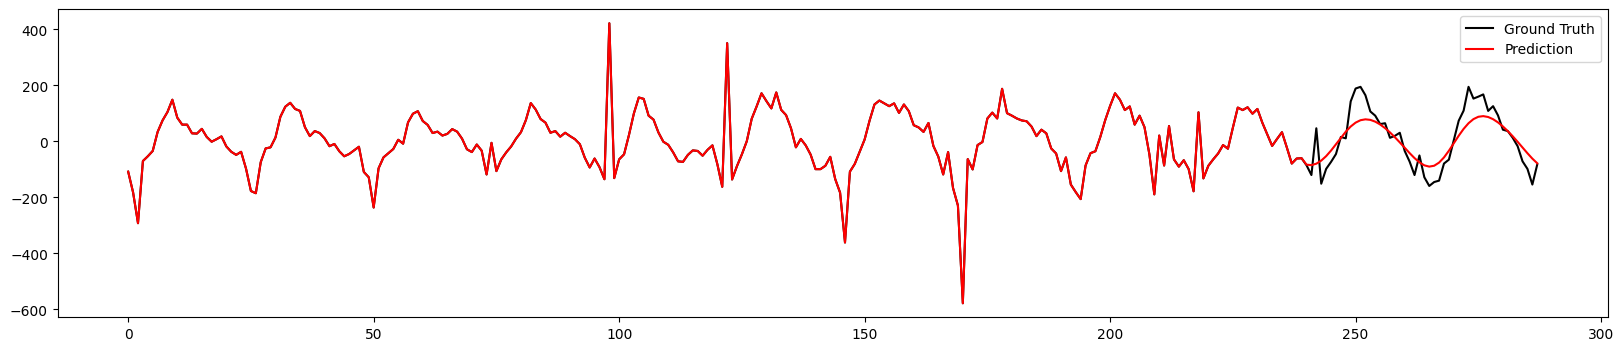

DAYTON_MW_DailyAvg


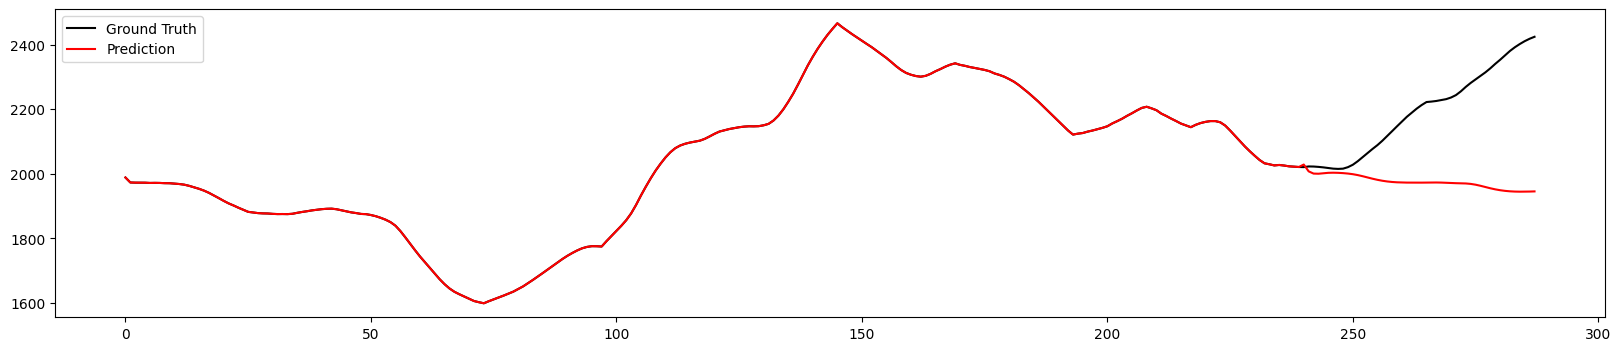

DAYTON_MW_DailyDiff


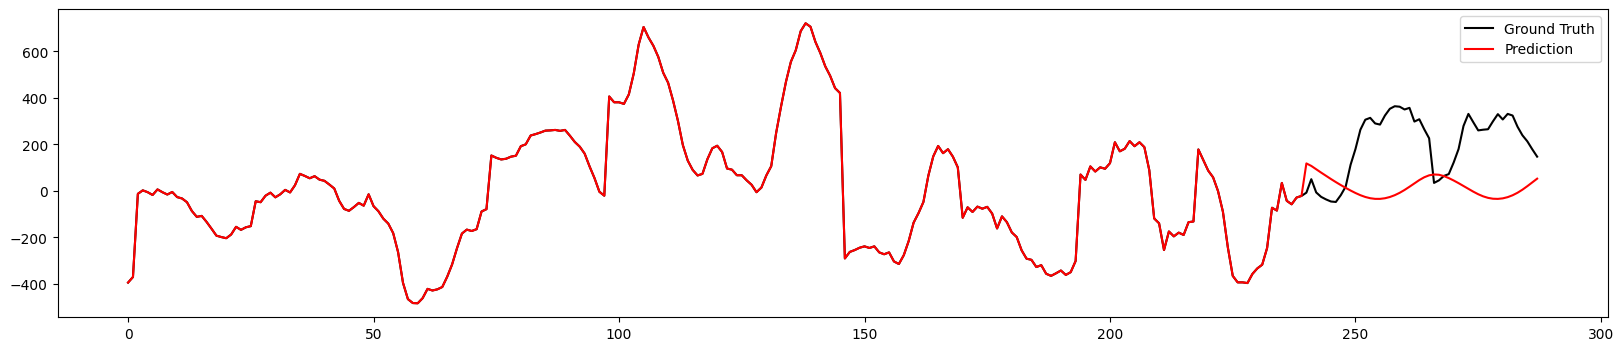

torch.Size([64, 48, 4])
DAYTON_MW


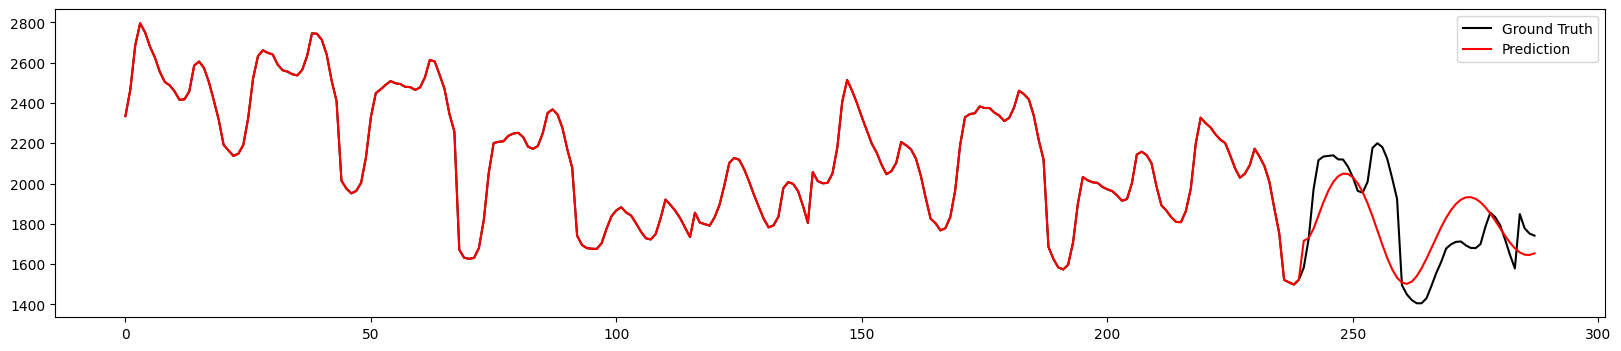

DAYTON_MW_Diff


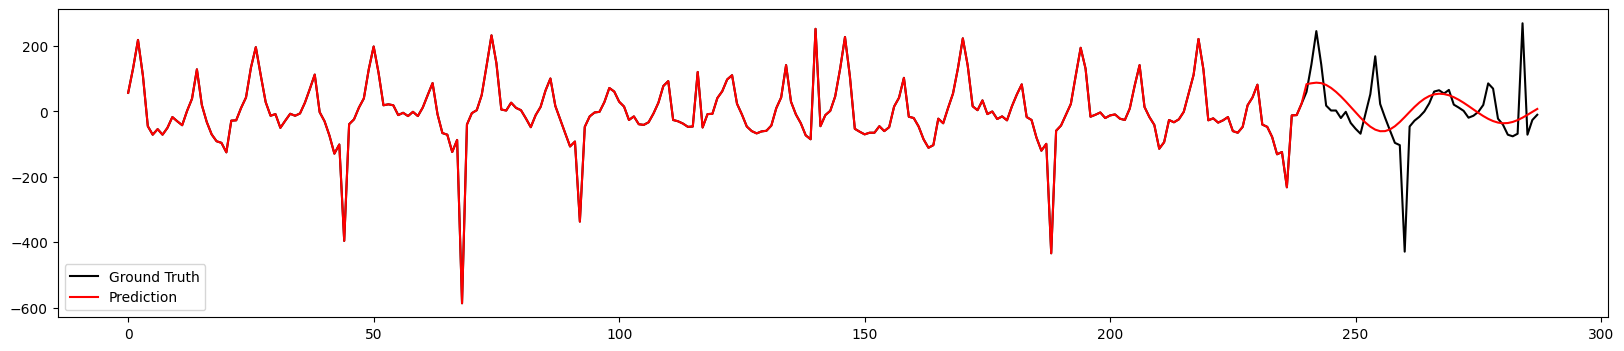

DAYTON_MW_DailyAvg


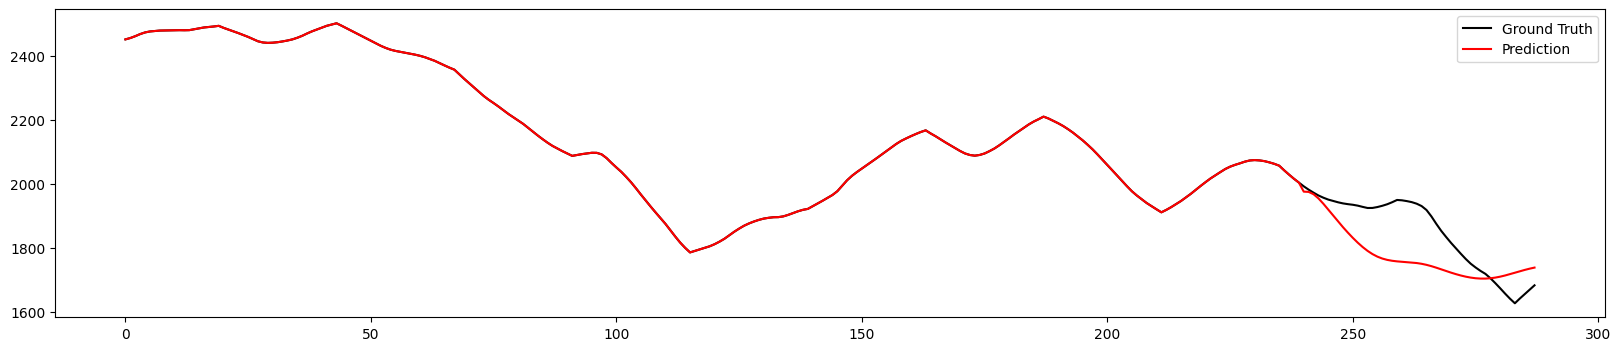

DAYTON_MW_DailyDiff


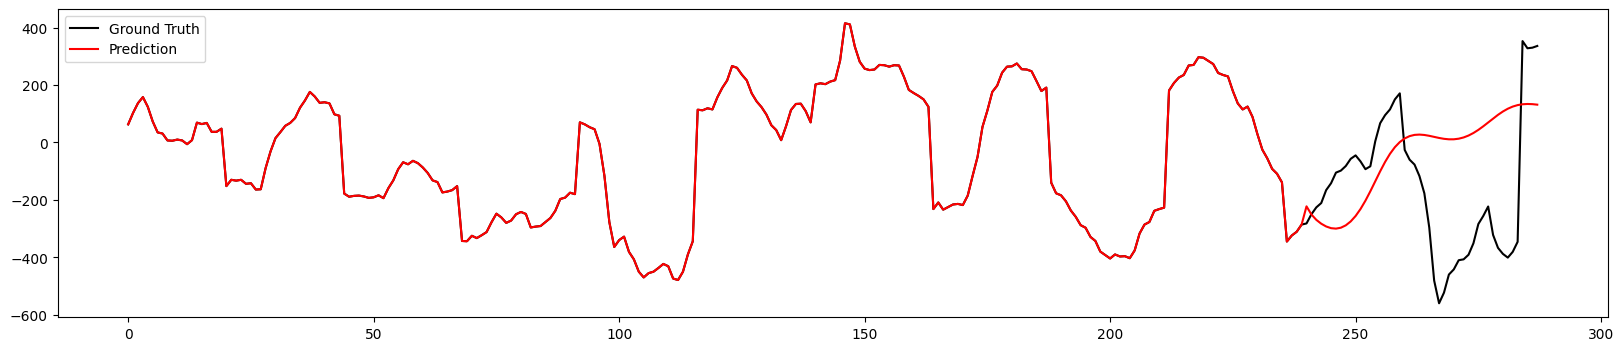

torch.Size([64, 48, 4])
DAYTON_MW


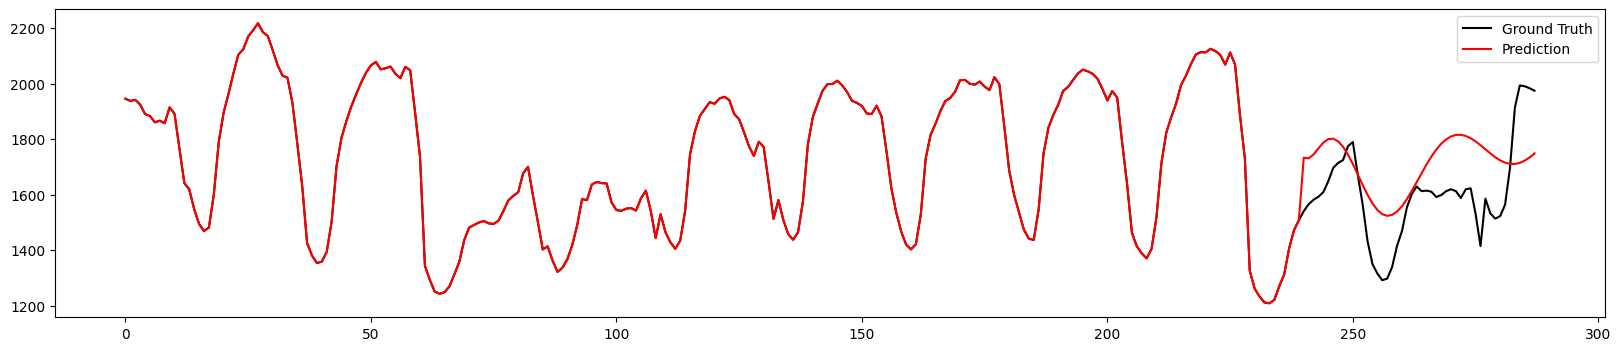

DAYTON_MW_Diff


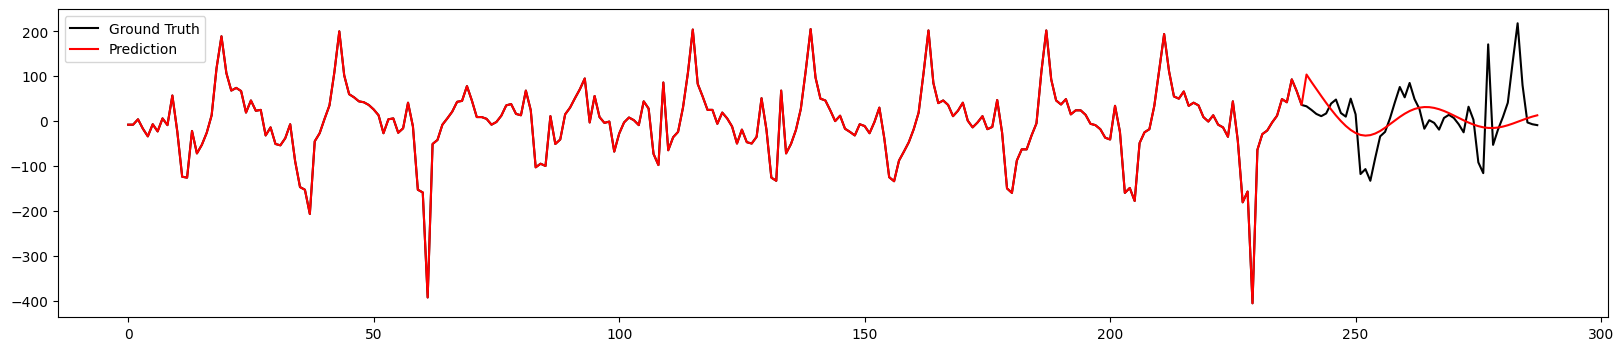

DAYTON_MW_DailyAvg


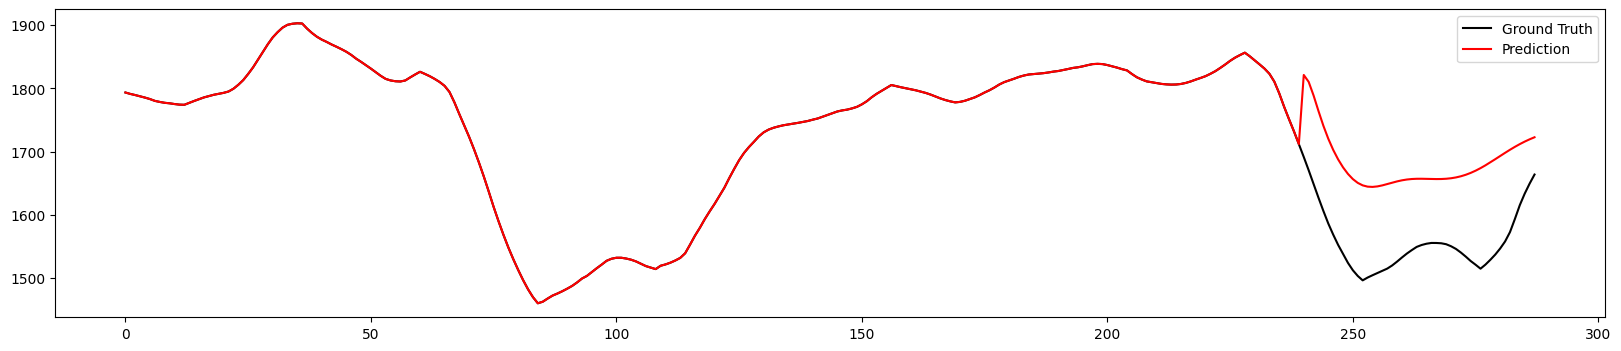

DAYTON_MW_DailyDiff


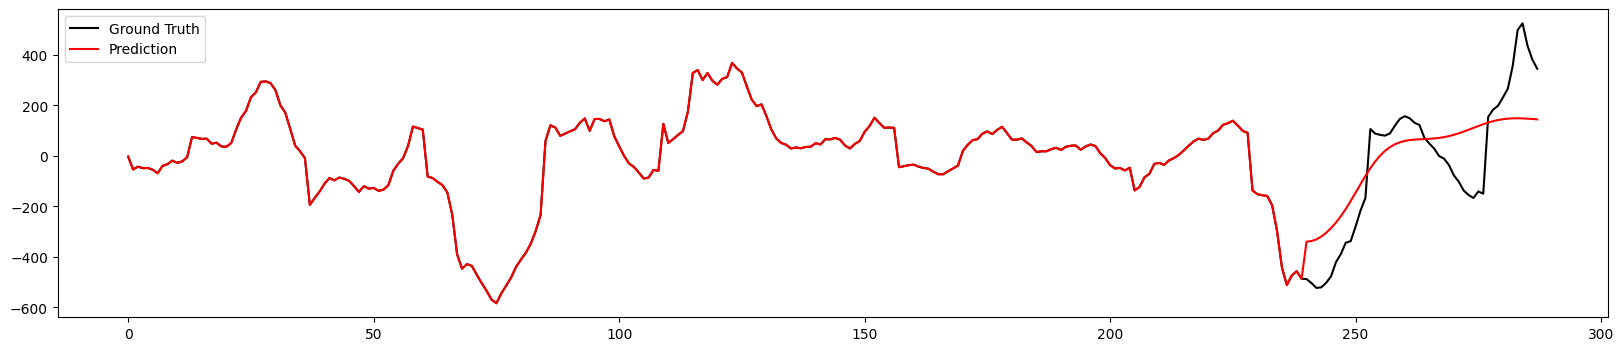

In [165]:
model = torch.load("model.pth")


for _ in range(3):
    model.eval()
    samples, targets = next(val_generator)
    output = make_predictions(model, samples, targets)
    print(output.shape)

    plot_predictions(header, samples, targets, output, mean, std)